In [1]:
#PETE 648 FINAL PROJECT: RTA
#KITTIPONG LIMCHUCHUA

import numpy as np
import math
import scipy.special as sci
from matplotlib import pyplot as plt

Name_plot = 114947
type = 'Bounded reservoir + Fractured well'
test_type = 'RTA'
pressure_type = 'variable BHP'
plot_raw_data = 'true'

#reservoir properties
phi_data = 0.088*(1-0.131) #0.088
h_data = 170

cr_data = 0
cg_data = 5.097542413316822e-05
ct_data = cr_data + cg_data
rw_data = 0.333
visc_data = 0.03604856910532351
#DPwf_data 
Bo_data = 0.5483710452483469
Pi_data = 7540.132771577818


#unknown parameters
k_match = 0.017 
xf_match = 112  
re_match = 491 #461 
b_match = 1 
FcD_match = 27 #15 


#import dataset from xlsx
import xlrd
#import col 0: shut-in time (t) in daya
#import col 1: rate data (STB/D)

L_smooth = 0.1
N_data = 4416
N_data_BHP = 4416

N_data_raw = 4860
N_data_BHP_raw = 4860

res_Excel = xlrd.open_workbook('Python_welltest_114947_Input.xlsx')

# read pressure form Excel file
if test_type == 'RTA' and pressure_type == 'constant BHP':  
    t = np.zeros((N_data,1)) #import time in Days
    qo = np.zeros((N_data,1)) 
    
    for i in range (0,N_data):
        t[i] = res_Excel.sheet_by_name('rate').cell(i,0).value
        qo[i] = res_Excel.sheet_by_name('rate').cell(i,1).value
    
    qo_i = np.zeros((N_data,1))
    t_MB = np.zeros((N_data,1))
    ln_t = np.log(t)
    
    
    sum_qo_i = 0
    for i in range (0,N_data):
        if i == 0:
            #sum_qo_i += (qo[i]+0)*(t[i]-0)/2
            B_power_int = np.log(qo[i+1]/qo[i])/np.log(t[i+1]/t[i])
            A_power_int = qo[i]/t[i]**B_power_int
            sum_qo_i = A_power_int/(B_power_int+1)*t[i]**(B_power_int+1)
        else:
            sum_qo_i += (qo[i]+qo[i-1])*(t[i]-t[i-1])/2
            
        qo_i[i] = sum_qo_i/t[i]
        t_MB[i] = sum_qo_i/qo[i]
            
    qo_id = np.zeros((N_data,1))
    #qo_id = qo_i - qo
        
    for i in range (0,N_data):
        if i == 0: #FFD for the first data
            qo_id[i] = (-1)*(qo_i[i+1]- qo_i[i])/(ln_t[i+1]-ln_t[i])
        elif i == N_data-1: #BFD for the first data
            qo_id[i] = (-1)*(qo_i[i]-qo_i[i-1])/(ln_t[i]-ln_t[i-1])
        else:
            iL = i-1
            iR = i+1
            iL_limit = i
            iR_limit = N_data - 1 - i
            i_count = 1
            while (np.log10(ln_t[i]/ln_t[iL])<L_smooth or np.log10(ln_t[iR]/ln_t[i])<L_smooth) and i_count<np.minimum(iL_limit,iR_limit):
                iL -= 1
                iR += 1
                i_count += 1

            qo_id[i] = (-1)*((qo_i[i]-qo_i[iL])/(ln_t[i]-ln_t[iL])**2+(qo_i[iR]-qo_i[i])/(ln_t[iR]-ln_t[i])**2)/(1/(ln_t[i]-ln_t[iL])+1/(ln_t[iR]-ln_t[i]))

            
            
if test_type == 'RTA' and pressure_type == 'variable BHP':  

    t_MB = np.zeros((N_data,1))  #import time in Days
    qo = np.zeros((N_data,1)) 
    Pwf = np.zeros((N_data,1)) 
    PNR = np.zeros((N_data,1)) #pressure-normalized rate
    RNP = np.zeros((N_data,1)) #rate-normalized pressure
    
    for i in range (0,N_data):
        t_MB[i] = res_Excel.sheet_by_name('rate').cell(i,0).value
        qo[i] = res_Excel.sheet_by_name('rate').cell(i,1).value
        Pwf[i] = res_Excel.sheet_by_name('pressure').cell(i,1).value
        PNR[i] = qo[i]/(Pi_data-Pwf[i])
        RNP[i] = (Pi_data-Pwf[i])/qo[i]
        
    
    if plot_raw_data == 'true':
        t_MB_raw = np.zeros((N_data_raw,1))  #import time in Days
        qo_raw = np.zeros((N_data_raw,1)) 
        Pwf_raw = np.zeros((N_data_raw,1)) 
        PNR_raw = np.zeros((N_data_raw,1)) #pressure-normalized rate
        RNP_raw = np.zeros((N_data_raw,1)) #rate-normalized pressure
        
        for i in range (0,N_data_raw):
                
            t_MB_raw[i] = res_Excel.sheet_by_name('rate(raw)').cell(i,0).value
            qo_raw[i] = res_Excel.sheet_by_name('rate(raw)').cell(i,1).value
            Pwf_raw[i] = res_Excel.sheet_by_name('pressure(raw)').cell(i,1).value
            PNR_raw[i] = qo_raw[i]/(Pi_data-Pwf_raw[i])
            RNP_raw[i] = (Pi_data-Pwf_raw[i])/qo_raw[i]
            
            
    #RNP/PNR-integral calculation
    PNR_i = np.zeros((N_data,1))
    RNP_i = np.zeros((N_data,1))
    ln_t_MB = np.log(t_MB)
    
    sum_qo_i = 0
    sum_PNR_i = 0
    sum_RNP_i = 0
    
    
    for i in range (0,N_data):
        if i == 0:
            B_power_int_PNR = np.log(PNR[i+1]/PNR[i])/np.log(t_MB[i+1]/t_MB[i])
            A_power_int_PNR = PNR[i]/t_MB[i]**B_power_int_PNR
            sum_PNR_i = A_power_int_PNR/(B_power_int_PNR+1)*t_MB[i]**(B_power_int_PNR+1)
            
            B_power_int_RNP = np.log(RNP[i+1]/RNP[i])/np.log(t_MB[i+1]/t_MB[i])
            A_power_int_RNP = PNR[i]/t_MB[i]**B_power_int_RNP
            sum_RNP_i = A_power_int_RNP/(B_power_int_RNP+1)*t_MB[i]**(B_power_int_RNP+1)
            
            #sum_PNR_i += (PNR[i]+0)*(t_MB[i]-0)/2
            #sum_RNP_i += (RNP[i]+0)*(t_MB[i]-0)/2
        else:
            sum_qo_i += (qo[i]+qo[i-1])*(t_MB[i]-t_MB[i-1])/2
            sum_PNR_i += (PNR[i]+PNR[i-1])*(t_MB[i]-t_MB[i-1])/2
            sum_RNP_i += (RNP[i]+RNP[i-1])*(t_MB[i]-t_MB[i-1])/2
            
        PNR_i[i] = sum_PNR_i/t_MB[i]
        RNP_i[i] = sum_RNP_i/t_MB[i]
     
    PNR_id = np.zeros((N_data,1))
    RNP_id = np.zeros((N_data,1))
    #qo_id = qo_i - qo
        
    for i in range (0,N_data):
        if i == 0: #FFD for the first data
            PNR_id[i] = (-1)*(PNR_i[i+1]- PNR_i[i])/(ln_t_MB[i+1]-ln_t_MB[i])
            RNP_id[i] = (-1)*(RNP_i[i+1]- RNP_i[i])/(ln_t_MB[i+1]-ln_t_MB[i])
        elif i == N_data-1: #BFD for the first data
            PNR_id[i] = (-1)*(PNR_i[i]-PNR_i[i-1])/(ln_t_MB[i]-ln_t_MB[i-1])
            RNP_id[i] = (-1)*(RNP_i[i]-RNP_i[i-1])/(ln_t_MB[i]-ln_t_MB[i-1])
        else:
            iL = i-1
            iR = i+1
            iL_limit = i
            iR_limit = N_data - 1 - i
            i_count = 1
            while (np.log10(ln_t_MB[i]/ln_t_MB[iL])<L_smooth or np.log10(ln_t_MB[iR]/ln_t_MB[i])<L_smooth) and i_count<np.minimum(iL_limit,iR_limit):
                iL -= 1
                iR += 1
                i_count += 1

            PNR_id[i] = (-1)*((PNR_i[i]-PNR_i[iL])/(ln_t_MB[i]-ln_t_MB[iL])**2+(PNR_i[iR]-PNR_i[i])/(ln_t_MB[iR]-ln_t_MB[i])**2)/(1/(ln_t_MB[i]-ln_t_MB[iL])+1/(ln_t_MB[iR]-ln_t_MB[i]))
            RNP_id[i] = (1)*((RNP_i[i]-RNP_i[iL])/(ln_t_MB[i]-ln_t_MB[iL])**2+(RNP_i[iR]-RNP_i[i])/(ln_t_MB[iR]-ln_t_MB[i])**2)/(1/(ln_t_MB[i]-ln_t_MB[iL])+1/(ln_t_MB[iR]-ln_t_MB[i]))
            
            
#convert data to the dimensionless form

if test_type == 'RTA' and pressure_type == 'constant BHP':  
    
    reD_match = re_match/xf_match  #Use rwa here and use reD for re/rwa only
    bD_pss_match = np.log(reD_match)-0.049298+0.434645*(reD_match)**(-2)
    qDd_match = 141.2*visc_data*Bo_data/k_match/h_data/DPwf_data*qo*bD_pss_match

    #be careful with rw and rwa here. The term from material balance should have original rw
    tDd_match = 6.329e-3*k_match*t/phi_data/visc_data/ct_data/xf_match**2/0.5/((reD_match)**2-1)/bD_pss_match
    qDdi_match = 141.2*visc_data*Bo_data/k_match/h_data/DPwf_data*qo_i*bD_pss_match
    qDdid_match = 141.2*visc_data*Bo_data/k_match/h_data/DPwf_data*qo_id*bD_pss_match

    #tDd_MB_match = 6.329e-3*k_match*t_MB/phi_data/visc_data/ct_data/xf_match**2/0.5/((reD_match)**2-1)/bD_pss_match
    #print(qDdi_match)
    #print(tDd_match)
    #print(ln_t)
    
if test_type == 'RTA' and pressure_type == 'variable BHP':  
    
    reD_match = re_match/xf_match  #Use rwa here and use reD for re/rwa only
    bD_pss_match = np.log(reD_match)-0.049298+0.434645*(reD_match)**(-2)
    
    a1 =  0.93626800 
    a2 =  -1.00489000 
    a3 =  0.31973300 
    a4 =  -0.04235320 
    a5 =  0.00221799 
    b1 =  -0.38553900 
    b2 =  -0.06988650 
    b3 =  -0.04846530
    b4 =  -0.00813558 
    k = np.log(reD_match)
    bD_pss_match += (a1+a2*k+a3*k**2+a4*k**3+a5*k**4)/(1+b1*k+b2*k**2+b3*k**3+b4*k**4)
    
    qDd_match = 141.2*visc_data*Bo_data/k_match/h_data*PNR*bD_pss_match
    qDdi_match = 141.2*visc_data*Bo_data/k_match/h_data*PNR_i*bD_pss_match
    qDdid_match = 141.2*visc_data*Bo_data/k_match/h_data*PNR_id*bD_pss_match
    tDd_MB_match = 6.329e-3*k_match*t_MB/phi_data/visc_data/ct_data/xf_match**2/0.5/((reD_match)**2-1)/bD_pss_match
    
    if plot_raw_data == 'true':
        tDd_MB_raw_match = 6.329e-3*k_match*t_MB_raw/phi_data/visc_data/ct_data/xf_match**2/0.5/((reD_match)**2-1)/bD_pss_match
        qDd_raw_match = 141.2*visc_data*Bo_data/k_match/h_data*PNR_raw*bD_pss_match

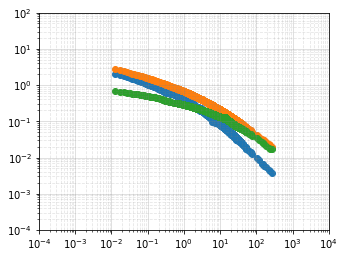

In [2]:
#PLOT RAW DATA
plt.scatter(tDd_MB_match,qDd_match)
plt.scatter(tDd_MB_match,qDdi_match)
plt.scatter(tDd_MB_match,qDdid_match)
plt.xscale('log')
plt.yscale('log')

ax = plt.gca()
ax.set_aspect('equal')

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-4, 1e+4, 1e-4, 1e+2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')

No handles with labels found to put in legend.


4.383928571428571


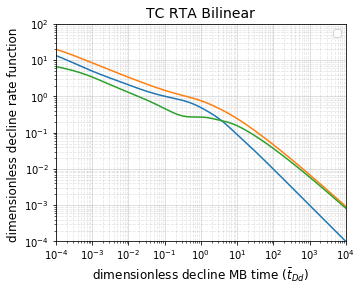

In [3]:
import numpy as np
import math
import scipy.special as sci
import scipy.integrate as integrate
from scipy.integrate import quad
import mpmath as mp
from matplotlib import pyplot as plt
print(reD_match)
#calculation of transient stem

#calculation of transient stem

def Gaver_Stehfest_RTA_Frac_circle(n,t,reD,FcD,isIntegrate):
    
    if n % 2 == 0:
        sum = 0;
        for i in range (1,n+1): #i = 1:n in MATLAB
            sum = sum+Vi(n,i)*fs_TPR(np.log(2)/t*i,reD,FcD,isIntegrate)
        
        sum = sum*np.log(2)/t
        return sum

def Vi(n,i):
    sum = 0
    for k in range(int(np.round((i+1)/2,1)), int(min(i,n/2)+1)):
        sum = sum + (k**(n/2))*math.factorial(2*k)/math.factorial(n/2-k)/math.factorial(k)/math.factorial(k-1)/math.factorial(i-k)/math.factorial(2*k-i)   

    sum = sum *(-1)**(n/2+i)
    return sum


def pD_LBD(s,FcD,sf):
    alpha = np.sqrt(s+np.sqrt(s))
    eta_f = 200*FcD
    psi = np.sqrt(2/FcD*alpha/(1+alpha*sf)+s/eta_f)
    return np.pi/s/FcD/psi/np.tanh(psi)
 
def xD_correct(FcD):
    a0 = 0.759919;
    a1 = 0.465301;
    a2 = 0.562754;
    a3 = 0.363093;
    a4 = 0.0298881;
    b0 = 1;
    b1 = 0.994770;
    b2 = 0.896679;
    b3 = 0.430707;
    b4 = 0.0467339;
    
    return (a0 + a1*np.log(FcD)+ a2*(np.log(FcD))**2 + a3*(np.log(FcD))**3 + a4*(np.log(FcD))**4)/(b0 + b1*np.log(FcD)+ b2*(np.log(FcD))**2 + b3*(np.log(FcD))**3 + b4*(np.log(FcD))**4)

def fs_TPR(s,reD,FcD,isIntegrate):
    
    return_fs = pD_LBD(s,FcD,0) - pD_LBD(s,10000,0) + fs_InfCon(s,reD,FcD)
    return_fs = 1/s**2/return_fs
    if isIntegrate == 1:
        return return_fs/s
    else:
        return return_fs
    
def fs_InfCon(s,reD,FcD):
   
        xD = xD_correct(FcD)
        
        #iti0k0 returns 0: i0-integral  1: k0-integral
        
        int_k0_1 =  sci.iti0k0(np.sqrt(s)*(1+xD))[1]
        int_k0_2 =  sci.iti0k0(np.sqrt(s)*(1-xD))[1]
        
        return_fs_1 = (int_k0_1+int_k0_2)/2/s/np.sqrt(s)
        
        int_i0_1 = sci.iti0k0(np.sqrt(s)*(1+xD))[0]
        int_i0_2 = sci.iti0k0(np.sqrt(s)*(1-xD))[0]
        return_fs_2 = 1/2/s/np.sqrt(s)*sci.k1(np.sqrt(s)*reD)/sci.i1(np.sqrt(s)*reD)*(int_i0_1+int_i0_2)
        
        return_fs = (return_fs_1+return_fs_2)
          
        return  return_fs

        
def bD_pss_calculate(reD,FcD):
    sum = 0
    sum += np.log(reD)-0.049298+0.43464*(reD)**(-2)
    a1 =  0.93626800 
    a2 =  -1.00489000 
    a3 =  0.31973300 
    a4 =  -0.04235320 
    a5 =  0.00221799 
    b1 =  -0.38553900 
    b2 =  -0.06988650 
    b3 =  -0.04846530
    b4 =  -0.00813558 
    k = np.log(reD)
    sum += (a1+a2*k+a3*k**2+a4*k**3+a5*k**4)/(1+b1*k+b2*k**2+b3*k**3+b4*k**4)
    return sum
        
#calculation of RTA dimensionless decline variable

def qDd_calculate(n,tDd,reD,FcD):
    bD_pss = bD_pss_calculate(reD,FcD)
    tD = tDd*0.5*((reD)**2-1)*bD_pss
    return Gaver_Stehfest_RTA_Frac_circle(n,tD,reD,FcD,0)*bD_pss

def qDdi_calculate(n,tDd,reD,FcD): #dimensonless rate-integral
    bD_pss = bD_pss_calculate(reD,FcD)
    tD = tDd*0.5*((reD)**2-1)*bD_pss
    return Gaver_Stehfest_RTA_Frac_circle(n,tD,reD,FcD,1)*bD_pss/tD

def qDdid_calculate(n,tDd,reD,FcD): #dimensonless rate-integral-derivative
    bD_pss = bD_pss_calculate(reD,FcD)
    return qDdi_calculate(n,tDd,reD,FcD)-qDd_calculate(n,tDd,reD,FcD)


#calculation of Arps stem
def qDd_Arps_exp(tDd):
    return np.exp(-tDd)

def qDd_Arps_hyperbolic(tDd,b):
    return 1/(1+b*tDd)**(1/b)

def qDd_Arps_harmonic(tDd):
    return 1/(1+tDd)

def qDdi_Arps_exp(tDd):
    return (1-np.exp(-tDd))/tDd

def qDdi_Arps_hyperbolic(tDd,b):
    return 1/tDd/(1-b)*(1-(1+b*tDd)**(1-1/b))

def qDdi_Arps_harmonic(tDd):
    return 1/tDd*np.log(1+tDd)

def qDdid_Arps_exp(tDd):
    return qDdi_Arps_exp(tDd)-qDd_Arps_exp(tDd)

def qDdid_Arps_hyperbolic(tDd,b):
    return qDdi_Arps_hyperbolic(tDd,b)-qDd_Arps_hyperbolic(tDd,b)

def qDdid_Arps_harmonic(tDd):
    return qDdi_Arps_harmonic(tDd)-qDd_Arps_harmonic(tDd)

#UNIVERSAL RTA HYBRID

def RTA_Bilinear_Hybrid(n,tDd,reD,FcD,b,function_type):
    
    if function_type == 0:
        
        if b < 1:
            qDd = qDd_calculate(n,tDd,reD,FcD) -  qDd_Arps_exp(tDd) + qDd_Arps_hyperbolic(tDd,b)
        else:
            qDd = qDd_calculate(n,tDd,reD,FcD) -  qDd_Arps_exp(tDd) + qDd_Arps_harmonic(tDd)
        return qDd
    
    elif function_type == 1:
        
        if b < 1:
            qDdi = qDdi_calculate(n,tDd,reD,FcD) -  qDdi_Arps_exp(tDd) + qDdi_Arps_hyperbolic(tDd,b)
        else:
            qDdi = qDdi_calculate(n,tDd,reD,FcD) -  qDdi_Arps_exp(tDd) + qDdi_Arps_harmonic(tDd)
        return qDdi
    else:
        
        if b < 1:
            qDdid = qDdid_calculate(n,tDd,reD,FcD) -  qDdid_Arps_exp(tDd) + qDdid_Arps_hyperbolic(tDd,b)
        else:
            qDdid = qDdid_calculate(n,tDd,reD,FcD) -  qDdid_Arps_exp(tDd) + qDdid_Arps_harmonic(tDd)
        return qDdid
         
#generate dataset for model
n = 6
#RTA_Bilinear_Hybrid(n,tDd,reD,FcD,b,function_type)
tDd_MB_mod = np.logspace(-4,4,num = 1000)
qDd_MB_mod = RTA_Bilinear_Hybrid(n,tDd_MB_mod,reD_match,FcD_match,1,0)
qDdi_MB_mod = RTA_Bilinear_Hybrid(n,tDd_MB_mod,reD_match,FcD_match,1,1)
qDdid_MB_mod = RTA_Bilinear_Hybrid(n,tDd_MB_mod,reD_match,FcD_match,1,2)

#print(qDdi_MB_mod )

ax = plt.gca()
ax.set_aspect('equal')

plt.loglog(tDd_MB_mod,qDd_MB_mod)
plt.loglog(tDd_MB_mod,qDdi_MB_mod)
plt.loglog(tDd_MB_mod,qDdid_MB_mod)

plt.title('TC RTA Bilinear',fontsize = 14)
plt.legend()

plt.xlabel('dimensionless decline MB time ' + r'$(\bar t_{Dd})$',fontsize = 12)
plt.ylabel('dimensionless decline rate function ',fontsize = 12)

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-4, 1e+4, 1e-4, 1e+2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')


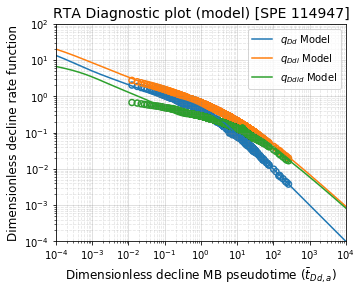

<Figure size 7200x7200 with 0 Axes>

In [4]:
#DIAGNOSTIC PLOT (LOG-LOG)- USING MB TIME

#plot data from model
Diagnostic_plot = plt.figure()

plt.loglog(tDd_MB_mod,qDd_MB_mod, label = r'$q_{Dd}$' +' Model')
plt.loglog(tDd_MB_mod,qDdi_MB_mod, label = r'$q_{Ddi}$' +' Model')
plt.loglog(tDd_MB_mod,qDdid_MB_mod, label = r'$q_{Ddid}$' +' Model')

#plot data from the match
plt.plot()
plt.scatter(tDd_MB_match,qDd_match,facecolors='none', edgecolors='C0',linewidth=1.5)
plt.scatter(tDd_MB_match,qDdi_match,facecolors='none', edgecolors='C1',linewidth=1.5)
plt.scatter(tDd_MB_match,qDdid_match,facecolors='none', edgecolors='C2',linewidth=1.5)


plt.xscale('log')
plt.yscale('log')

#control legend + plotting mechanics 
plt.legend()

plt.title('RTA Diagnostic plot (model) [SPE '+str(Name_plot)+']',fontsize = 14)
plt.xlabel('Dimensionless decline MB pseudotime ' + r'$(\bar t_{Dd,a})$',fontsize = 12)
plt.ylabel('Dimensionless decline rate function',fontsize = 12)

ax = plt.gca()
ax.set_aspect('equal')
ax.axis([1e-4, 1e+4, 1e-4, 1e+2])

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)

plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.figure(figsize=(100,100))
Diagnostic_plot.savefig(str(Name_plot)+'_Diagnostic_RTA.png', dpi=500)

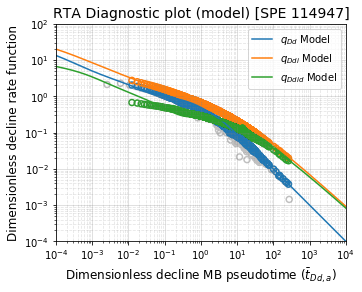

<Figure size 7200x7200 with 0 Axes>

In [5]:
if plot_raw_data == 'true':
    #DIAGNOSTIC PLOT (LOG-LOG)- USING MB TIME

    #plot data from model
    Diagnostic_raw_plot = plt.figure()

    plt.loglog(tDd_MB_mod,qDd_MB_mod, label = r'$q_{Dd}$' +' Model')
    plt.loglog(tDd_MB_mod,qDdi_MB_mod, label = r'$q_{Ddi}$' +' Model')
    plt.loglog(tDd_MB_mod,qDdid_MB_mod, label = r'$q_{Ddid}$' +' Model')

    #plot data from the match
    plt.plot()
    plt.scatter(tDd_MB_match,qDd_match,facecolors='none', edgecolors='C0',linewidth=1.5)
    plt.scatter(tDd_MB_match,qDdi_match,facecolors='none', edgecolors='C1',linewidth=1.5)
    plt.scatter(tDd_MB_match,qDdid_match,facecolors='none', edgecolors='C2',linewidth=1.5)
    plt.scatter(tDd_MB_raw_match,qDd_raw_match,facecolors='none', edgecolors='silver',linewidth=1.5,zorder=0)


    plt.xscale('log')
    plt.yscale('log')

    #control legend + plotting mechanics 
    plt.legend()

    plt.title('RTA Diagnostic plot (model) [SPE '+str(Name_plot)+']',fontsize = 14)
    plt.xlabel('Dimensionless decline MB pseudotime ' + r'$(\bar t_{Dd,a})$',fontsize = 12)
    plt.ylabel('Dimensionless decline rate function',fontsize = 12)

    ax = plt.gca()
    ax.set_aspect('equal')
    ax.axis([1e-4, 1e+4, 1e-4, 1e+2])

    import matplotlib.ticker as ticker
    locmaj = ticker.LogLocator(base=10,numticks=14) 
    ax.xaxis.set_major_locator(locmaj)

    plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
    plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
    plt.figure(figsize=(100,100))
    Diagnostic_raw_plot.savefig(str(Name_plot)+'_Diagnostic_raw.png', dpi=500)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  func(*args, **kwargs)
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  fig.canvas.print_figure(bytes_io, **kw)


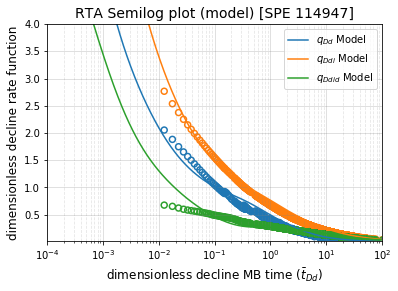

<Figure size 7200x7200 with 0 Axes>

In [6]:
#SEMI_LOG PLOT

#plot data from model
Semilog_plot = plt.figure()

plt.plot(tDd_MB_mod,qDd_MB_mod, label = r'$q_{Dd}$' +' Model')
plt.plot(tDd_MB_mod,qDdi_MB_mod, label = r'$q_{Ddi}$' +' Model')
plt.plot(tDd_MB_mod,qDdid_MB_mod, label = r'$q_{Ddid}$' +' Model')

#plot data from the match
plt.plot()
plt.scatter(tDd_MB_match,qDd_match,facecolors='none', edgecolors='C0',linewidth=1.5)
plt.scatter(tDd_MB_match,qDdi_match,facecolors='none', edgecolors='C1',linewidth=1.5)
plt.scatter(tDd_MB_match,qDdid_match,facecolors='none', edgecolors='C2',linewidth=1.5)


plt.xscale('log')
#plt.yscale('log')

#control legend + plotting mechanics 
plt.legend()

plt.title('RTA Semilog plot (model) [SPE '+str(Name_plot)+']',fontsize = 14)
plt.xlabel('dimensionless decline MB time ' + r'$(\bar t_{Dd})$',fontsize = 12)
plt.ylabel('dimensionless decline rate function',fontsize = 12)

ax = plt.gca()
ax.set_aspect('equal')
ax.axis([1e-4, 1e+2, 1e-2, 4])

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)

plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
plt.figure(figsize=(100,100))
Semilog_plot.savefig(str(Name_plot)+'_Semilog.png', dpi=500)

In [7]:
#ERROR REPORT

Opt_matrix = np.zeros((N_data,5))
#RTA_Bilinear_Hybrid(n,tDd,reD,FcD,b,function_type)

for i in range (0,N_data):
    
    Opt_matrix[i,0] = tDd_MB_match[i]
    Opt_matrix[i,1] = RTA_Bilinear_Hybrid(n,tDd_MB_match[i],reD_match,FcD_match,b_match,0)
    Opt_matrix[i,2] = 141.2*visc_data*Bo_data/k_match/h_data*PNR[i]*bD_pss_match
    Opt_matrix[i,3] = RTA_Bilinear_Hybrid(n,tDd_MB_match[i],reD_match,FcD_match,b_match,1)
    Opt_matrix[i,4] = 141.2*visc_data*Bo_data/k_match/h_data*PNR_i[i]*bD_pss_match
    
if tDd_MB_match[0] == 0:
    Opt_matrix_str = np.delete(Opt_matrix,0,0)
    Opt_matrix = Opt_matrix_str

sum_sqr = 0
for i in range (0,Opt_matrix.shape[0]):
    if Opt_matrix[i,1] !=0 and Opt_matrix[i,2] != 0:
        sum_sqr += (Opt_matrix[i,1]-Opt_matrix[i,2])**2
    if Opt_matrix[i,3] !=0 and Opt_matrix[i,4] != 0:
        sum_sqr += (Opt_matrix[i,3]-Opt_matrix[i,4])**2
   
print(sum_sqr)

12.069982107915177


In [8]:
#OPTIMIZATION BOX

def Sum_sqr_error(k_val,re_val,xf_val,FcD_val,b_val):
    
    Opt_matrix_local = np.zeros((N_data,5))
    
    reD_val = re_val/xf_val
    bD_pss_val = np.log(reD_val)-0.049298+0.434645*(reD_val)**(-2)
    
    tDd_MB_val = 6.329e-3*k_val*t_MB/phi_data/visc_data/ct_data/xf_val**2/0.5/((reD_val)**2-1)/bD_pss_val
    
    for i in range (0,N_data): 
        Opt_matrix_local[i,0] = tDd_MB_val[i]
        Opt_matrix_local[i,1] = RTA_Bilinear_Hybrid(n,tDd_MB_val[i],reD_val,FcD_val,b_val,0)
        Opt_matrix_local[i,2] = 141.2*visc_data*Bo_data/k_val/h_data*PNR[i]*bD_pss_val
        Opt_matrix_local[i,3] = RTA_Bilinear_Hybrid(n,tDd_MB_val[i],reD_val,FcD_val,b_val,1)
        Opt_matrix_local[i,4] = 141.2*visc_data*Bo_data/k_val/h_data*PNR_i[i]*bD_pss_val

        
    sum_sqr_local = 0
    for i in range (0,Opt_matrix_local.shape[0]):
        if Opt_matrix_local[i,1] !=0 and Opt_matrix_local[i,2] != 0:
            sum_sqr_local += (Opt_matrix_local[i,1]-Opt_matrix_local[i,2])**2
        if Opt_matrix_local[i,3] !=0 and Opt_matrix_local[i,4] != 0:
            sum_sqr_local += (Opt_matrix_local[i,3]-Opt_matrix_local[i,4])**2
    return sum_sqr_local

def eggholder(Opt_var):
    return Sum_sqr_error(Opt_var[0],Opt_var[1],Opt_var[2],Opt_var[3],Opt_var[4])

bounds = [(0.016, 0.018), (450,470),(110,116),(10,30),(0.999,1)]

from scipy import optimize
results = dict()
results['shgo'] = optimize.shgo(eggholder, bounds)
results['shgo']

     fun: 7.040614937348469
    funl: array([7.04061494])
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 2
   nlfev: 7
   nlhev: 0
   nljev: 1
 success: True
       x: array([1.60e-02, 4.50e+02, 1.10e+02, 1.00e+01, 9.99e-01])
      xl: array([[1.60e-02, 4.50e+02, 1.10e+02, 1.00e+01, 9.99e-01]])

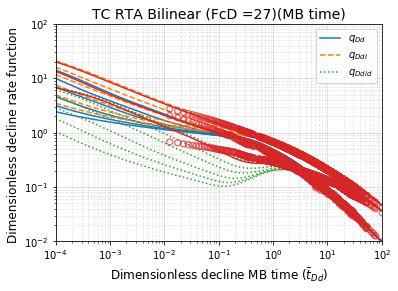

In [9]:
tDd_mod = np.logspace(-4,4,num = 1000)

qDd_mod_re_rw_4 = RTA_Bilinear_Hybrid(n,tDd_mod,4,FcD_match,1,0)
qDd_mod_re_rw_7 = RTA_Bilinear_Hybrid(n,tDd_mod,7,FcD_match,1,0)
qDd_mod_re_rw_12 = RTA_Bilinear_Hybrid(n,tDd_mod,12,FcD_match,1,0)
qDd_mod_re_rw_25 = RTA_Bilinear_Hybrid(n,tDd_mod,25,FcD_match,1,0)
qDd_mod_re_rw_50 = RTA_Bilinear_Hybrid(n,tDd_mod,50,FcD_match,1,0)
qDd_mod_re_rw_100 = RTA_Bilinear_Hybrid(n,tDd_mod,100,FcD_match,1,0)
qDd_mod_best_match = RTA_Bilinear_Hybrid(n,tDd_mod,reD_match,FcD_match,1,0)

qDdi_mod_re_rw_4 = RTA_Bilinear_Hybrid(n,tDd_mod,4,FcD_match,1,1)
qDdi_mod_re_rw_7 = RTA_Bilinear_Hybrid(n,tDd_mod,7,FcD_match,1,1)
qDdi_mod_re_rw_12 = RTA_Bilinear_Hybrid(n,tDd_mod,12,FcD_match,1,1)
qDdi_mod_re_rw_25 = RTA_Bilinear_Hybrid(n,tDd_mod,25,FcD_match,1,1)
qDdi_mod_re_rw_50 = RTA_Bilinear_Hybrid(n,tDd_mod,50,FcD_match,1,1)
qDdi_mod_re_rw_100 = RTA_Bilinear_Hybrid(n,tDd_mod,100,FcD_match,1,1)
qDdi_mod_best_match = RTA_Bilinear_Hybrid(n,tDd_mod,reD_match,FcD_match,1,1)

qDdid_mod_re_rw_4 = RTA_Bilinear_Hybrid(n,tDd_mod,4,FcD_match,1,2)
qDdid_mod_re_rw_7 = RTA_Bilinear_Hybrid(n,tDd_mod,7,FcD_match,1,2)
qDdid_mod_re_rw_12 = RTA_Bilinear_Hybrid(n,tDd_mod,12,FcD_match,1,2)
qDdid_mod_re_rw_25 = RTA_Bilinear_Hybrid(n,tDd_mod,25,FcD_match,1,2)
qDdid_mod_re_rw_50 = RTA_Bilinear_Hybrid(n,tDd_mod,50,FcD_match,1,2)
qDdid_mod_re_rw_100 = RTA_Bilinear_Hybrid(n,tDd_mod,100,FcD_match,1,2)
qDdid_mod_best_match = RTA_Bilinear_Hybrid(n,tDd_mod,reD_match,FcD_match,1,2)


Type_curve_MB_plot = plt.figure()

ax = plt.gca()
ax.set_aspect('equal')


#plotting transient stems
plt.loglog(tDd_mod,qDd_mod_re_rw_4, color='C0',label = r'$q_{Dd}$ ')
plt.loglog(tDd_mod,qDd_mod_re_rw_7, color='C0')
plt.loglog(tDd_mod,qDd_mod_re_rw_12, color='C0')
plt.loglog(tDd_mod,qDd_mod_re_rw_25, color='C0')
plt.loglog(tDd_mod,qDd_mod_re_rw_50, color='C0')
plt.loglog(tDd_mod,qDd_mod_re_rw_100, color='C0')

plt.loglog(tDd_mod,qDdi_mod_re_rw_4, '--', color='C1',label = r'$q_{Ddi}$ ')
plt.loglog(tDd_mod,qDdi_mod_re_rw_7, '--', color='C1')
plt.loglog(tDd_mod,qDdi_mod_re_rw_12, '--', color='C1')
plt.loglog(tDd_mod,qDdi_mod_re_rw_25, '--', color='C1')
plt.loglog(tDd_mod,qDdi_mod_re_rw_50, '--', color='C1')
plt.loglog(tDd_mod,qDdi_mod_re_rw_100, '--', color='C1')

plt.loglog(tDd_mod,qDdid_mod_re_rw_4, ':', color='C2', label = r'$q_{Ddid}$ ')
plt.loglog(tDd_mod,qDdid_mod_re_rw_7, ':', color='C2')
plt.loglog(tDd_mod,qDdid_mod_re_rw_12, ':', color='C2')
plt.loglog(tDd_mod,qDdid_mod_re_rw_25, ':', color='C2')
plt.loglog(tDd_mod,qDdid_mod_re_rw_50, ':', color='C2')
plt.loglog(tDd_mod,qDdid_mod_re_rw_100, ':', color='C2')


plt.loglog(tDd_mod,qDd_mod_best_match, color='C3')
plt.loglog(tDd_mod,qDdi_mod_best_match, color='C3')
plt.loglog(tDd_mod,qDdid_mod_best_match, color='C3')

#plot data from the match
plt.plot()
plt.scatter(tDd_MB_match,qDd_match,facecolors='none', edgecolors='C3',linewidth=1.5,zorder=10,alpha = 0.6)
plt.scatter(tDd_MB_match,qDdi_match,facecolors='none', edgecolors='C3',linewidth=1.5,zorder=10,alpha = 0.6)
plt.scatter(tDd_MB_match,qDdid_match,facecolors='none', edgecolors='C3',linewidth=1.5,zorder=10,alpha = 0.6)


plt.title('TC RTA Bilinear (FcD ='+str(FcD_match)+')(MB time)',fontsize = 14)
plt.legend()

plt.xlabel('Dimensionless decline MB time ' + r'$(\bar t_{Dd})$',fontsize = 12)
plt.ylabel('Dimensionless decline rate function ',fontsize = 12)

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-4, 1e+2, 1e-2, 1e+2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')

Type_curve_MB_plot.savefig(str(Name_plot)+'_TC_RTA_Bilinear_MB.png', dpi=400)